# **Financial Analysis and Trading Strategies (WORK IN PROGRESS)**

## **Contents**
1) [Introduction](#Introduction)
2) [Moving Average Strategy](#Trend-Following)
3) [Bollinger Bands Strategy](#Bollinger-Bands)
4) [Fibonacci Retracement Strategy](#Fibonacci-Retracement)
5) [Credits](#Credits)

The purpose of this project is to implement the trading signals of some basic trading startegies using Python. The `numpy`, `scipy`, `pandas`, `matplotlib`, `seaborn`, `warnings`, `riskfolio`, `pypfopt` and `yfinance` libraries are imported for use. Moreover, the plot styles are set for aesthetic reasons and some warnings are ignored (as they are concerned with unused features in this project at the time of conception).

In [1]:
import time as tm
import datetime as dt
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wrn
import riskfolio as rsk
import pypfopt as ppf
import yfinance as yf

palette = sns.color_palette("viridis_r", as_cmap=True)
sns.set_style(style = "whitegrid", rc = {"font.family":"Times New Roman", "font.weight":"bold"})
wrn.filterwarnings(action = "ignore")

Expected Return: 0.19% (47.02%, if annualised)
Volatility: 2.73% (43.36%, if annualised)
Sharpe Ratio: 0.07 (1.08 if annaualised)
Total cumulative return: 45.63%
Maximum drawdown: -43.34 units of local currncy


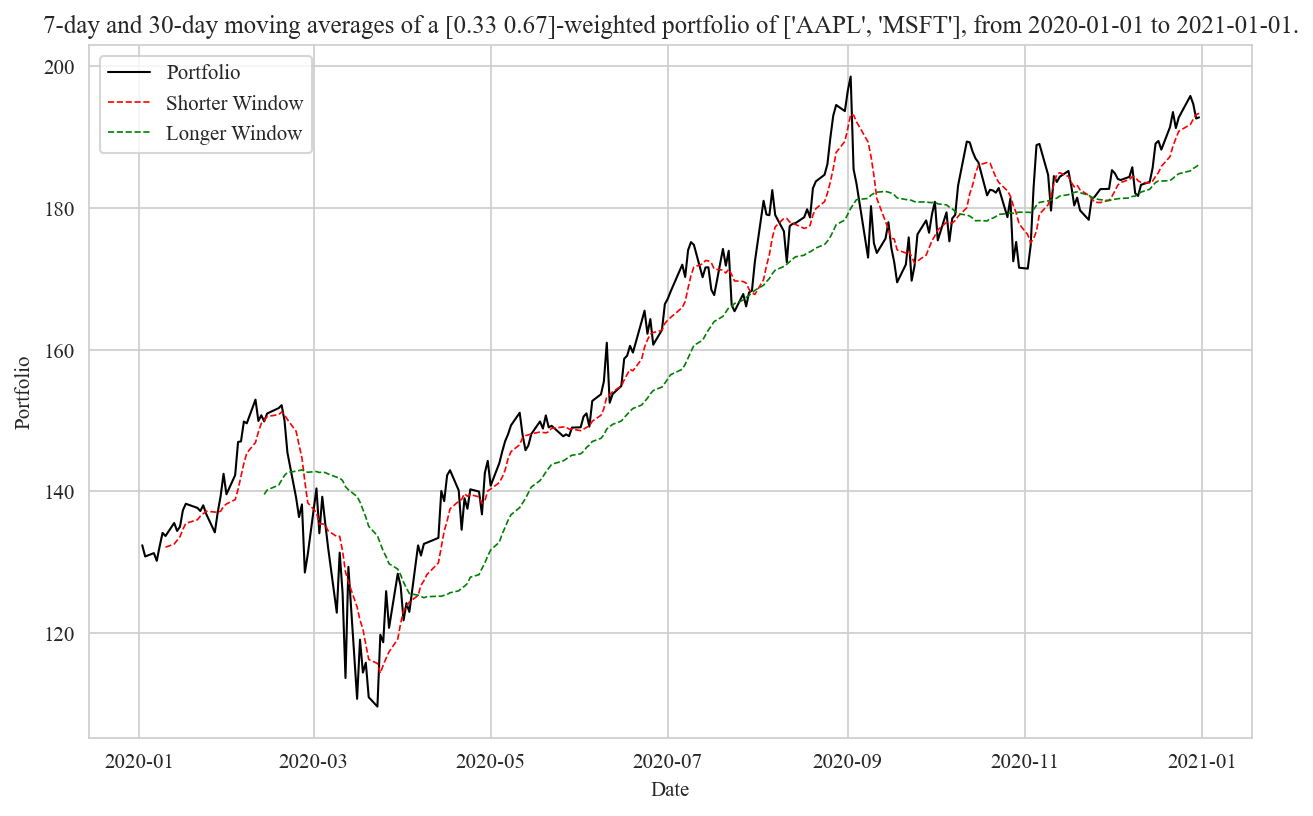

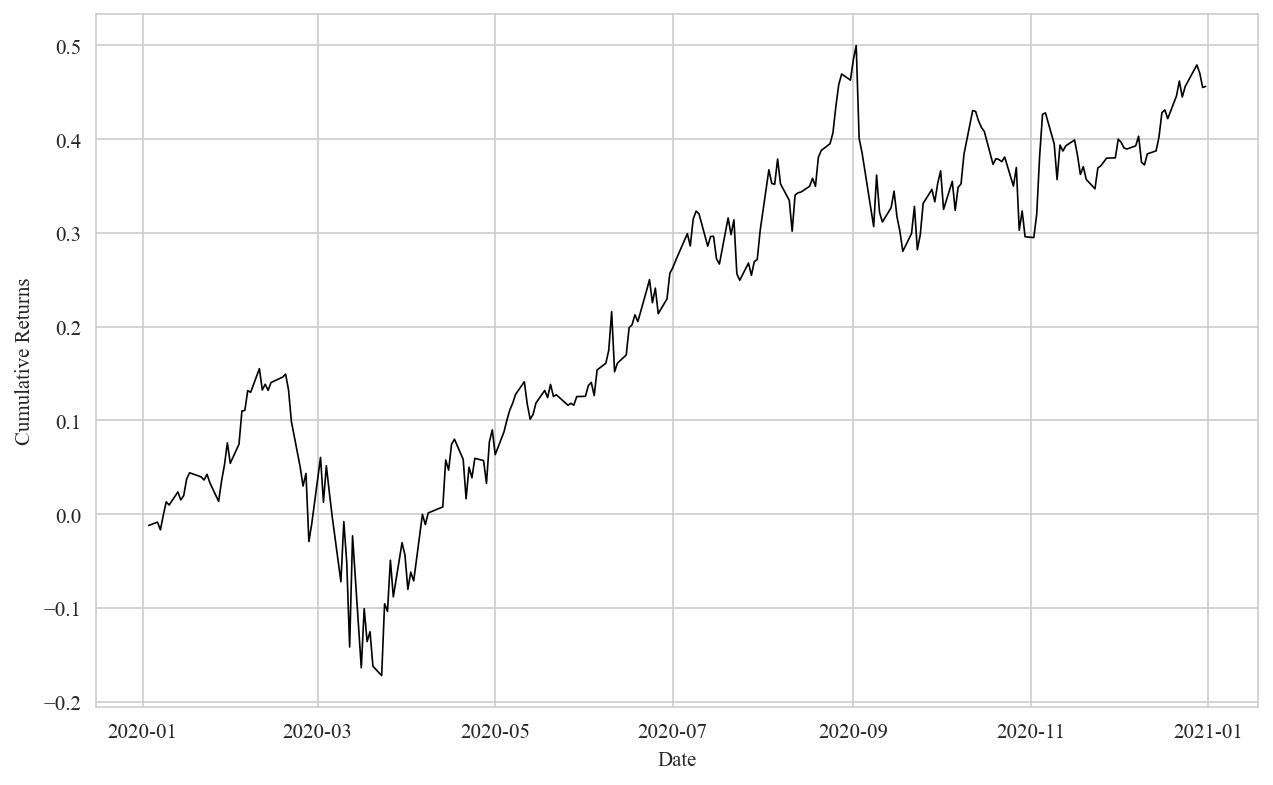

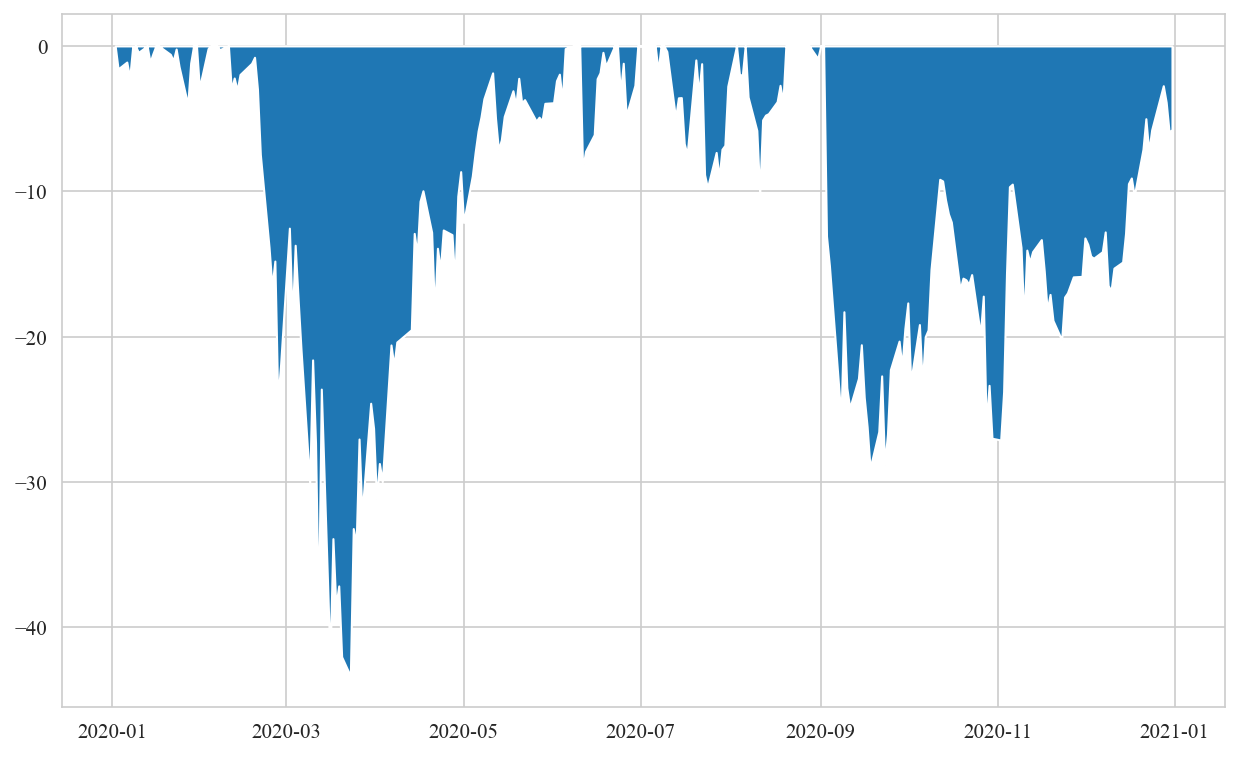

In [78]:
def moving_average_strategy(tickers, weights, start_date, end_date, window_1, window_2, show_performance_metrics = False, show_visualisations = False):
    """
    Generates the trading signals of a moving average trading strategy for a pair of lookback windows.
    """
    assert all(isinstance(d, t) for d, t in zip([tickers, weights, start_date, end_date, window_1, window_2], [list, list, str, str, int, int])), "At least one argument has the wrong data type. Please check the function docstring for more guidance."
    assert all(isinstance(ticker, str) for ticker in tickers), "At least one ticker element is of the wrong data type. Please ensure all tickers are in string format."
    assert sum(weights) == 1, "The portfolio must be capital budgeted. Please ensure that the weights sum up to 1."
    assert dt.datetime.strptime(start_date, "%Y-%m-%d") < dt.datetime.strptime(end_date, "%Y-%m-%d"), "The start date must strictly precede the end date"
    assert 1 < min(window_1, window_2) and window_1 != window_2, "The lookback windows must be strictly greater than one and cannot coincide."
    shorter_window, longer_window = min(window_1, window_2), max(window_1, window_2)
    df = yf.download(tickers, start_date, end_date, progress = False)["Close"]
    weights = np.round(weights, 2)
    if len(tickers) == 1:
        df = pd.DataFrame({
            "Date" : df.index,
            "Portfolio" : df.values
        })
    else:
        df["Portfolio"] = np.dot(weights, df.T)
    df["Shorter Window"] = df["Portfolio"].rolling(shorter_window).mean()
    df["Longer Window"] = df["Portfolio"].rolling(longer_window).mean()
    df["Returns"] = df["Portfolio"].pct_change()
    df["Cumulative Returns"] = df["Returns"].add(1).cumprod().sub(1)
    df["Drawdown"] =  df["Portfolio"] - df["Portfolio"].cummax()
    df["Trading Signals"] = 0
    df.loc[df["Shorter Window"] > df["Longer Window"], "Trading Signals"] = 1
    df.loc[df["Shorter Window"] < df["Longer Window"], "Trading Signals"] = -1
    if show_performance_metrics:
        expected_return = df["Returns"].mean()
        volatility = df["Returns"].std()
        sharpe_ratio = expected_return / volatility
        total_cumulative_return = df["Cumulative Returns"].values[-1]
        maximum_drawdown = df["Drawdown"].min()
        print(f"Expected Return: {expected_return:.2%} ({252 * expected_return:.2%}, if annualised)")
        print(f"Volatility: {volatility:.2%} ({np.sqrt(252) * volatility:.2%}, if annualised)")
        print(f"Sharpe Ratio: {sharpe_ratio:.2f} ({np.sqrt(252) * sharpe_ratio:.2f} if annaualised)")
        print(f"Total cumulative return: {total_cumulative_return:.2%}")
        print(f"Maximum drawdown: {maximum_drawdown:.2f} units of local currncy")
    else:
        pass
    if show_visualisations:
        plt.figure(figsize=(10, 6), dpi = 150)
        for b, c, w, s in zip(["Portfolio", "Shorter Window", "Longer Window"], ["black", "red", "green"], [1, 0.8, 0.8], ["-", "--", "--"]):
            sns.lineplot(data = df, x = "Date", y = b, color = c, linewidth = w, linestyle = s, label = b)
        plt.legend()
        plt.title(f"{shorter_window}-day and {longer_window}-day moving averages of a {weights}-weighted portfolio of {tickers}, from {start_date} to {end_date}.")
        plt.figure(figsize=(10, 6), dpi = 150)
        sns.lineplot(data = df, x = "Date", y = "Cumulative Returns", color = "black", linewidth = 0.8, linestyle = "-")
        plt.figure(figsize=(10, 6), dpi = 150)
        plt.fill_between(x = df.index, y1 = df["Drawdown"])
    else:
        pass
    return df

t = moving_average_strategy(["AAPL", "MSFT"], [1/3, 2/3], "2020-01-01", "2021-01-01", 7, 30, show_performance_metrics=True, show_visualisations = True)

In [ ]:
def bollinger_bands_strategy(tickers, weights, start_date, end_date, window):
    """
    Generates the trading signals of a Bollinger bands trading strategy for a of lookback window.
    """
    assert all(isinstance(d, t) for d, t in zip([tickers, weights, start_date, end_date, window], [list, list, str, str, int])), "At least one argument has the wrong data type. Please check the function docstring for more guidance."
    assert all(isinstance(ticker, str) for ticker in tickers), "At least one ticker element is of the wrong data type. Please ensure all tickers are in string format."
    assert sum(weights) == 1, "The portfolio must be capital budgeted. Please ensure that the weights sum up to 1."
    assert dt.datetime.strptime(start_date, "%Y-%m-%d") < dt.datetime.strptime(end_date, "%Y-%m-%d"), "The start date must strictly precede the end date"
    assert 1 < window, "The lookback window must be strictly greater than one."
    df = yf.download(tickers, start_date, end_date, progress = False)["Close"]
    if len(tickers) == 1:
        df = pd.DataFrame({
            "Date" : df.index,
            "Portfolio" : df.values
        })
    else:
        df["Portfolio"] = np.dot(weights, df.T)
    df["Middle Band"] = df["Portfolio"].rolling(window).mean()
    df["Lower Band"] = df["Middle Band"] - 2 * df["Portfolio"].rolling(window).std()
    df["Upper Band"] = df["Middle Band"] + 2 * df["Portfolio"].rolling(window).std()
    df["Trading Signals"] = 0
    df.loc[df["Portfolio"] > df["Upper Band"], "Trading Signals"] = -1
    df.loc[(df["Lower Band"] < 2 * df["Portfolio"] - df["Middle Band"]) & (df["Upper Band"] > 2 * df["Portfolio"] - df["Middle Band"]), "Trading Signals"] = 0
    df.loc[df["Portfolio"] < df["Lower Band"], "Trading Signals"] = 1
    trading_signals = pd.DataFrame({
        "Date" : df["Date"],
        "Trading Signals" : df["Trading Signals"]
    })
    return trading_signals

bollinger_bands_strategy(["AAPL"], [1], "2020-01-01", "2021-01-01", 14)

,Date,Trading Signals
0,2020-01-02,0
1,2020-01-03,0
2,2020-01-06,0
3,2020-01-07,0
4,2020-01-08,0
...,...,...
248,2020-12-24,0
249,2020-12-28,-1
250,2020-12-29,0
251,2020-12-30,0
